单股单维度RNN基础训练过程（单只股票【AAPL】，不处理过拟合问题）

1.准备数据

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.optim as optim

# Load data that we deed
data = pd.read_csv('all_stocks_5yr.csv')

stock_data = data[data['Name'] == 'AAPL']

stock_data = stock_data[['date', 'close']]

# Sort,Normalize
stock_data['date'] = pd.to_datetime(stock_data['date'])

stock_data = stock_data.sort_values('date')

scaler = MinMaxScaler(feature_range=(0, 1))
stock_data['close'] = scaler.fit_transform(stock_data[['close']])

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

2.定义RNN结构

In [25]:
# RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Only take the output from the last time step
        return out

3.训练函数，评价函数和预测函数

In [26]:
def train_model(model, X_train, y_train, num_epochs, criterion, optimizer):
    model.train()
    for epoch in range(num_epochs):
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = criterion(predictions, y_test)
    return mse.item()

def predict(model, X):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
    return predictions

4.训练并可视化

Epoch [10/100], Loss: 0.0252
Epoch [20/100], Loss: 0.0219
Epoch [30/100], Loss: 0.0205
Epoch [40/100], Loss: 0.0166
Epoch [50/100], Loss: 0.0115
Epoch [60/100], Loss: 0.0041
Epoch [70/100], Loss: 0.0020
Epoch [80/100], Loss: 0.0009
Epoch [90/100], Loss: 0.0006
Epoch [100/100], Loss: 0.0006
RNN Test MSE: 0.0081


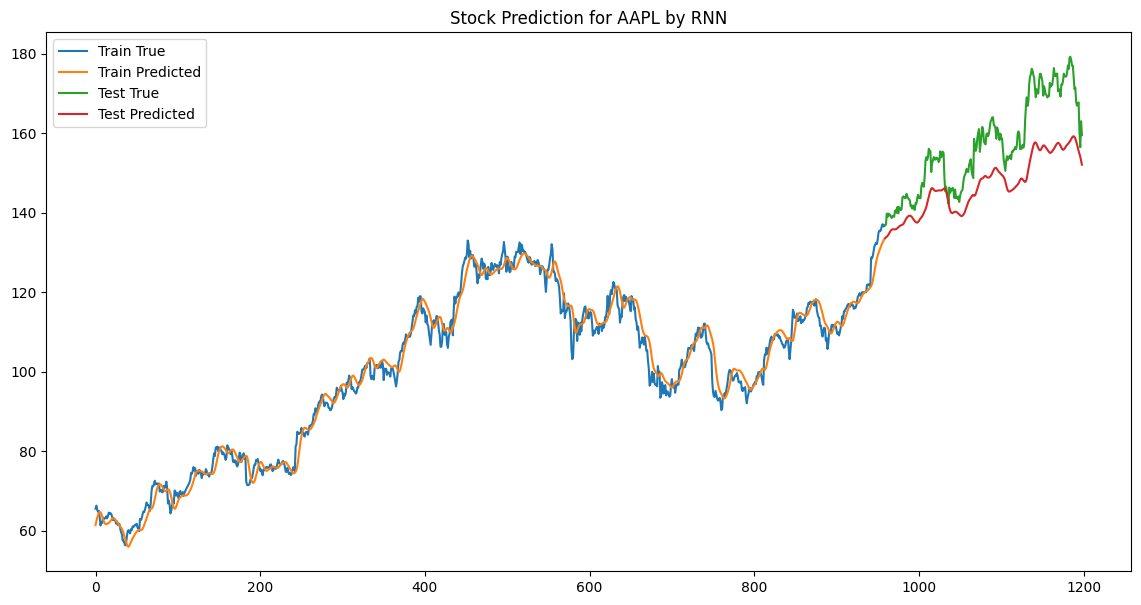

In [27]:
seq_length = 60
X, y = create_sequences(stock_data['close'].values, seq_length)

# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.from_numpy(X_train).float().unsqueeze(-1)
y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
X_test = torch.from_numpy(X_test).float().unsqueeze(-1)
y_test = torch.from_numpy(y_test).float().unsqueeze(-1)

input_size = 1
hidden_size = 50
output_size = 1
num_epochs = 100
learning_rate = 0.001

rnn_model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)

train_model(rnn_model, X_train, y_train, num_epochs, criterion, optimizer)

rnn_mse = evaluate_model(rnn_model, X_test, y_test)
print(f'RNN Test MSE: {rnn_mse:.4f}')

# Predict
train_predictions = predict(rnn_model, X_train)
test_predictions = predict(rnn_model, X_test)

# Inverse transform the predictions and true values
train_predictions = scaler.inverse_transform(train_predictions.numpy())
test_predictions = scaler.inverse_transform(test_predictions.numpy())
y_train = scaler.inverse_transform(y_train.numpy())
y_test = scaler.inverse_transform(y_test.numpy())

train_results = pd.DataFrame(data={'True': y_train.flatten(), 'Predicted': train_predictions.flatten()})
test_results = pd.DataFrame(data={'True': y_test.flatten(), 'Predicted': test_predictions.flatten()})

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train_results['True'], label='Train True')
plt.plot(train_results['Predicted'], label='Train Predicted')
plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['True'], label='Test True')
plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['Predicted'], label='Test Predicted')
plt.title(f'Stock Prediction for AAPL by RNN')
plt.legend()
plt.show()

分析：测试集MSE偏高，说明预测精度可以通过增加数据量等方式进一步提高，从股价预测图像上来看，训练集拟合较好，但是测试集拟合不够，训练集MSE显著低于测试集MSE，需要增加数据量和采取防止过拟合方法进行训练。

改进1.1：增加扩大数据量，增加到四只股预测模型，同时增加epochs数量，使用dropout和L2正则化使得模型避免过拟合问题。

改进1.2：加入验证集进一步防止过拟合(效果也不好)

Epoch [10/200], Loss: 0.0444, Val Loss: 0.0669
Epoch [20/200], Loss: 0.0376, Val Loss: 0.0550
Epoch [30/200], Loss: 0.0310, Val Loss: 0.0407
Epoch [40/200], Loss: 0.0203, Val Loss: 0.0259
Epoch [50/200], Loss: 0.0050, Val Loss: 0.0039
Epoch [60/200], Loss: 0.0037, Val Loss: 0.0034
Epoch [70/200], Loss: 0.0036, Val Loss: 0.0036
Epoch [80/200], Loss: 0.0029, Val Loss: 0.0031
Epoch [90/200], Loss: 0.0026, Val Loss: 0.0029
Epoch [100/200], Loss: 0.0028, Val Loss: 0.0027
Epoch [110/200], Loss: 0.0025, Val Loss: 0.0029
Epoch [120/200], Loss: 0.0026, Val Loss: 0.0031
Epoch [130/200], Loss: 0.0025, Val Loss: 0.0027
Epoch [140/200], Loss: 0.0025, Val Loss: 0.0028
Epoch [150/200], Loss: 0.0025, Val Loss: 0.0025
Epoch [160/200], Loss: 0.0024, Val Loss: 0.0025
Epoch [170/200], Loss: 0.0024, Val Loss: 0.0025
Epoch [180/200], Loss: 0.0023, Val Loss: 0.0023
Epoch [190/200], Loss: 0.0023, Val Loss: 0.0026
Epoch [200/200], Loss: 0.0023, Val Loss: 0.0023
RNN Test MSE: 0.0002


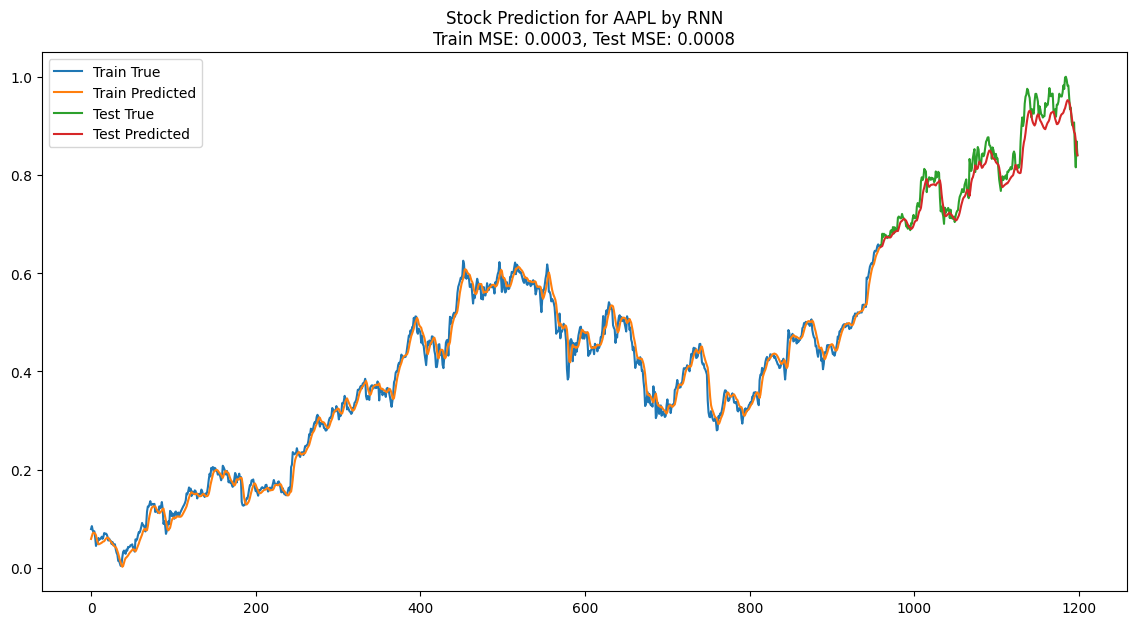

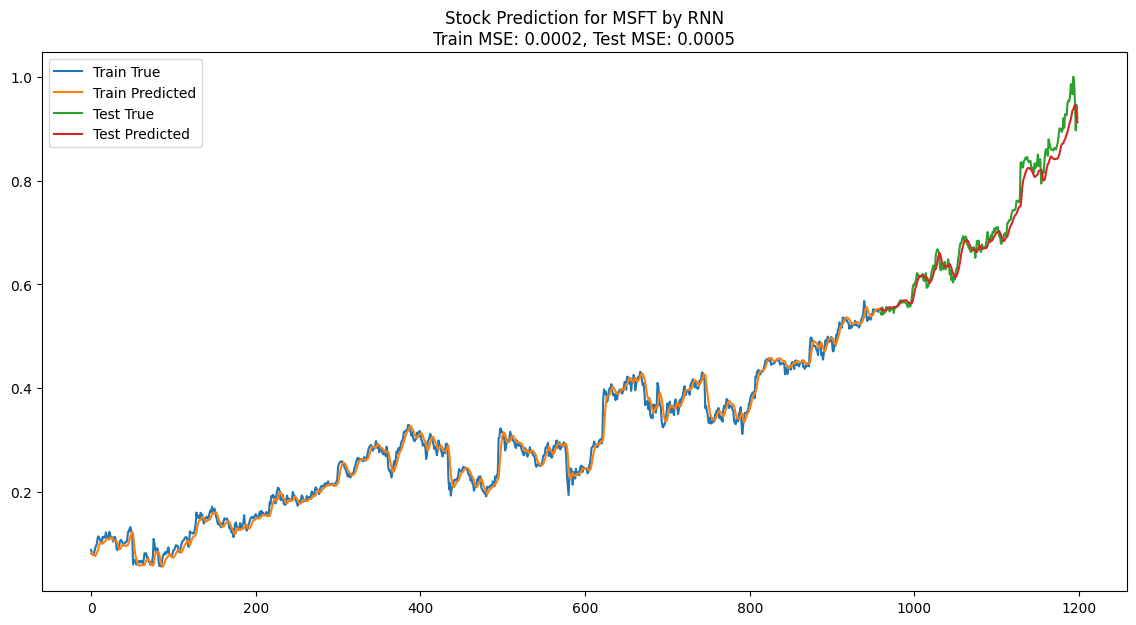

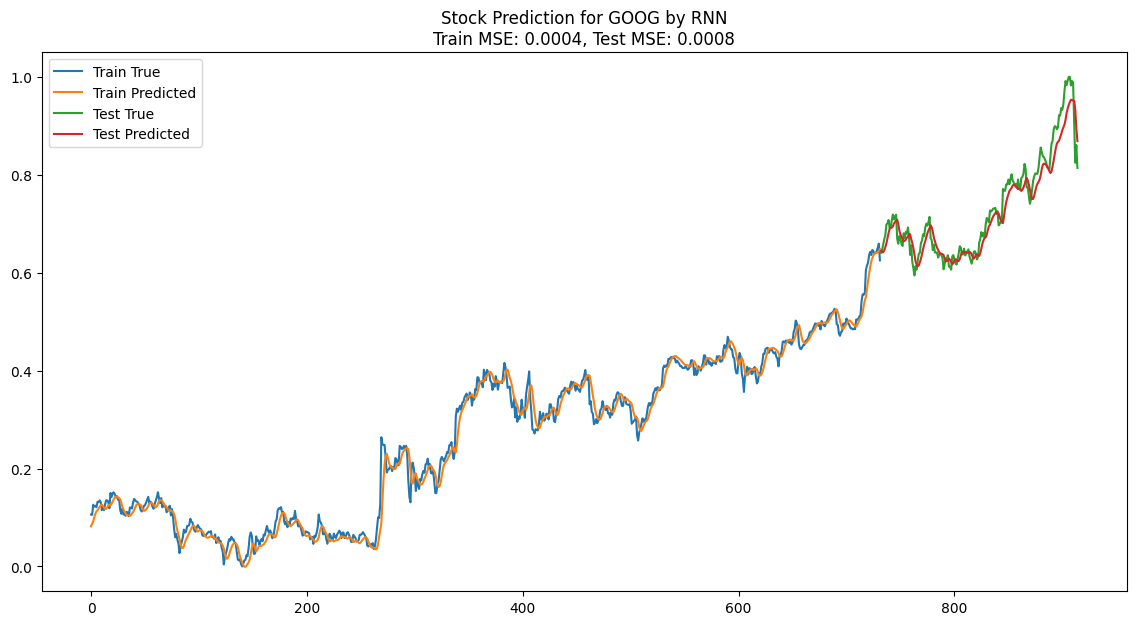

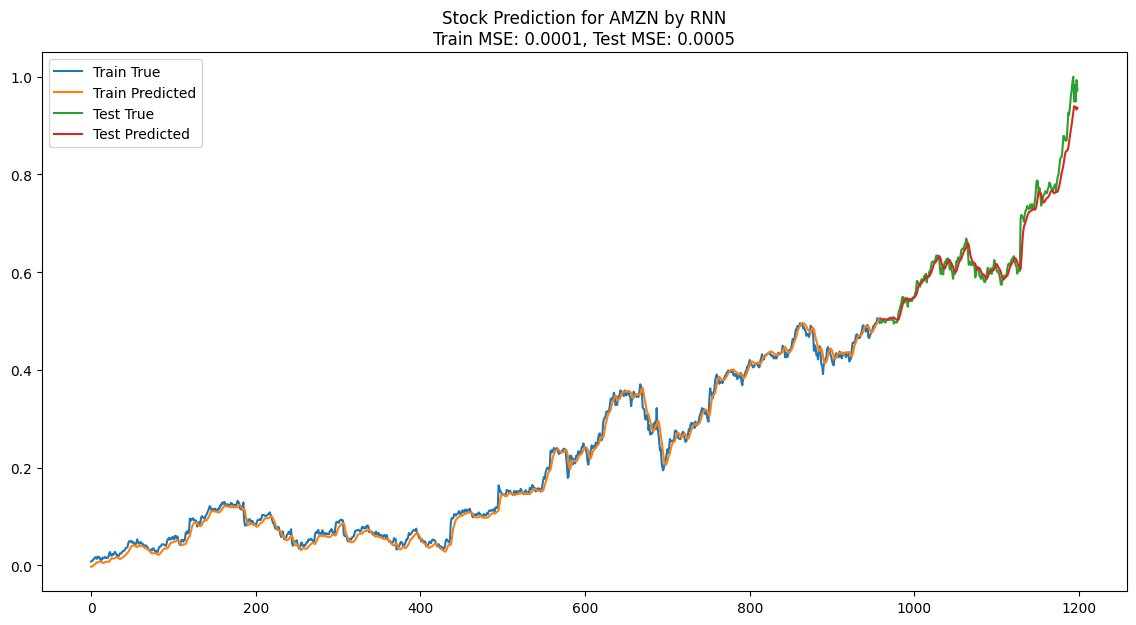

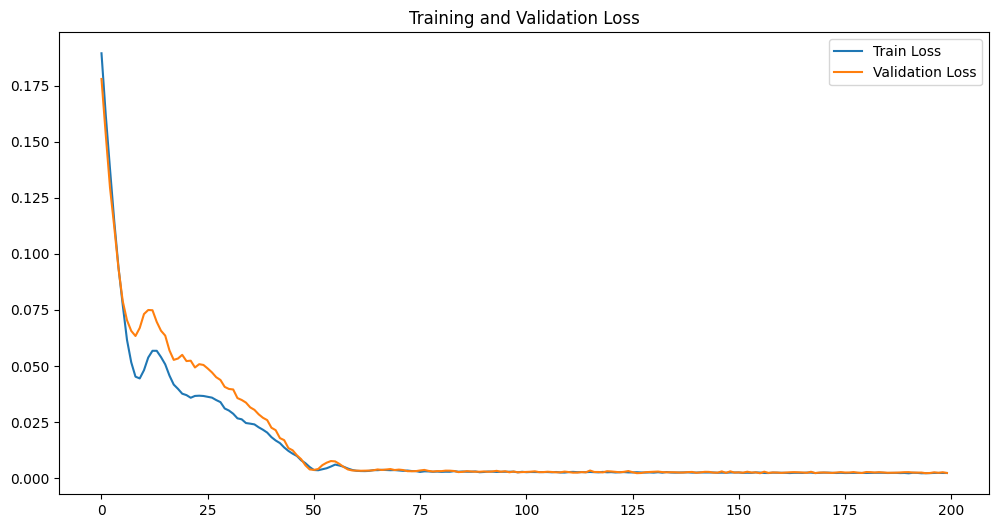

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

data = pd.read_csv('all_stocks_5yr.csv')

# Normalize
def normalize_stock_data(stock_name):
    stock_data = data[data['Name'] == stock_name]
    stock_data = stock_data[['date', 'close']]
    stock_data['date'] = pd.to_datetime(stock_data['date'])
    stock_data = stock_data.sort_values('date')
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data['close'] = scaler.fit_transform(stock_data[['close']])
    return stock_data, scaler

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Prepare data for multiple stocks
def prepare_data(stock_names, seq_length=60):
    X, y = [], []
    scalers = {}
    for stock_name in stock_names:
        stock_data, scaler = normalize_stock_data(stock_name)
        stock_sequences, stock_labels = create_sequences(stock_data['close'].values, seq_length)
        X.extend(stock_sequences)
        y.extend(stock_labels)
        scalers[stock_name] = scaler
    X, y = np.array(X), np.array(y)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    X_train = torch.from_numpy(X_train).float().unsqueeze(-1)
    y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
    X_test = torch.from_numpy(X_test).float().unsqueeze(-1)
    y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
    return X_train, y_train, X_test, y_test, scalers

# Prepare data for a single stock
def prepare_single_stock_data(stock_name, seq_length=60):
    stock_data, scaler = normalize_stock_data(stock_name)
    X, y = create_sequences(stock_data['close'].values, seq_length)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    X_train = torch.from_numpy(X_train).float().unsqueeze(-1)
    y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
    X_test = torch.from_numpy(X_test).float().unsqueeze(-1)
    y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
    return X_train, y_train, X_test, y_test, scaler

#RNN model with dropout
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.rnn(x, h0)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])  # Only take the output from the last time step
        return out

# Training function
def train_model(model, X_train, y_train, X_val, y_val, num_epochs, criterion, optimizer):
    model.train()
    loss_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        
        loss_history.append(loss.item())
        val_loss_history.append(val_loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
    return model, loss_history, val_loss_history

# Evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = nn.MSELoss()(predictions, y_test)
    return predictions, mse.item()

# Plot 
def plot_results(train_results, test_results, stock_name, train_mse, test_mse):
    plt.figure(figsize=(14, 7))
    plt.plot(train_results['True'], label='Train True')
    plt.plot(train_results['Predicted'], label='Train Predicted')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['True'], label='Test True')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['Predicted'], label='Test Predicted')
    plt.legend()
    plt.title(f'Stock Prediction for {stock_name} by RNN\nTrain MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
    plt.show()

stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN']
X_train, y_train, X_test, y_test, scalers = prepare_data(stocks)

val_size = int(len(X_train) * 0.2)
X_val, y_val = X_train[-val_size:], y_train[-val_size:]
X_train, y_train = X_train[:-val_size], y_train[:-val_size]

input_size = 1
hidden_size = 50
output_size = 1
num_epochs = 200
learning_rate = 0.001
weight_decay = 1e-5 

rnn_model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

rnn_model, train_loss_history, val_loss_history = train_model(rnn_model, X_train, y_train, X_val, y_val, num_epochs, criterion, optimizer)

predictions, mse = evaluate_model(rnn_model, X_test, y_test)
print(f'RNN Test MSE: {mse:.4f}')

def predict_and_plot_stock(stock_name):
    X_train_stock, y_train_stock, X_test_stock, y_test_stock, scaler_stock = prepare_single_stock_data(stock_name)
    
    train_predictions_stock = rnn_model(X_train_stock).detach().cpu().numpy()
    test_predictions_stock = rnn_model(X_test_stock).detach().cpu().numpy()
    
    train_mse_stock = np.mean((y_train_stock.cpu().numpy() - train_predictions_stock)**2)
    test_mse_stock = np.mean((y_test_stock.cpu().numpy() - test_predictions_stock)**2)
    
    train_results_stock = pd.DataFrame(data={'True': y_train_stock.cpu().numpy().flatten(), 'Predicted': train_predictions_stock.flatten()})
    test_results_stock = pd.DataFrame(data={'True': y_test_stock.cpu().numpy().flatten(), 'Predicted': test_predictions_stock.flatten()})
    
    plot_results(train_results_stock, test_results_stock, stock_name, train_mse_stock, test_mse_stock)

for stock in stocks:
    predict_and_plot_stock(stock)

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

改进2：每一支股票单独预测模型，但是增加输入信息（包括）

Epoch [10/200], Loss: 0.0293
Epoch [20/200], Loss: 0.0131
Epoch [30/200], Loss: 0.0055
Epoch [40/200], Loss: 0.0028
Epoch [50/200], Loss: 0.0026
Epoch [60/200], Loss: 0.0020
Epoch [70/200], Loss: 0.0017
Epoch [80/200], Loss: 0.0018
Epoch [90/200], Loss: 0.0017
Epoch [100/200], Loss: 0.0016
Epoch [110/200], Loss: 0.0016
Epoch [120/200], Loss: 0.0016
Epoch [130/200], Loss: 0.0014
Epoch [140/200], Loss: 0.0015
Epoch [150/200], Loss: 0.0013
Epoch [160/200], Loss: 0.0013
Epoch [170/200], Loss: 0.0012
Epoch [180/200], Loss: 0.0013
Epoch [190/200], Loss: 0.0012
Epoch [200/200], Loss: 0.0012
AAPL Test MSE: 0.0019


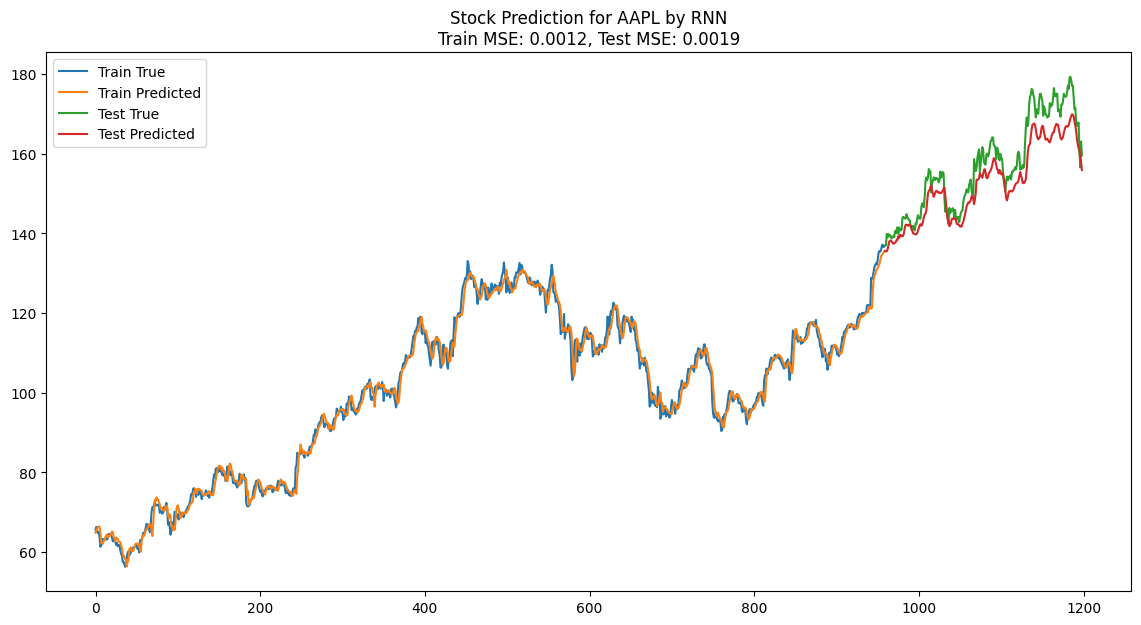

Epoch [10/200], Loss: 0.0211
Epoch [20/200], Loss: 0.0110
Epoch [30/200], Loss: 0.0069
Epoch [40/200], Loss: 0.0037
Epoch [50/200], Loss: 0.0026
Epoch [60/200], Loss: 0.0024
Epoch [70/200], Loss: 0.0021
Epoch [80/200], Loss: 0.0021
Epoch [90/200], Loss: 0.0021
Epoch [100/200], Loss: 0.0021
Epoch [110/200], Loss: 0.0018
Epoch [120/200], Loss: 0.0019
Epoch [130/200], Loss: 0.0017
Epoch [140/200], Loss: 0.0016
Epoch [150/200], Loss: 0.0016
Epoch [160/200], Loss: 0.0015
Epoch [170/200], Loss: 0.0015
Epoch [180/200], Loss: 0.0016
Epoch [190/200], Loss: 0.0016
Epoch [200/200], Loss: 0.0014
MSFT Test MSE: 0.0014


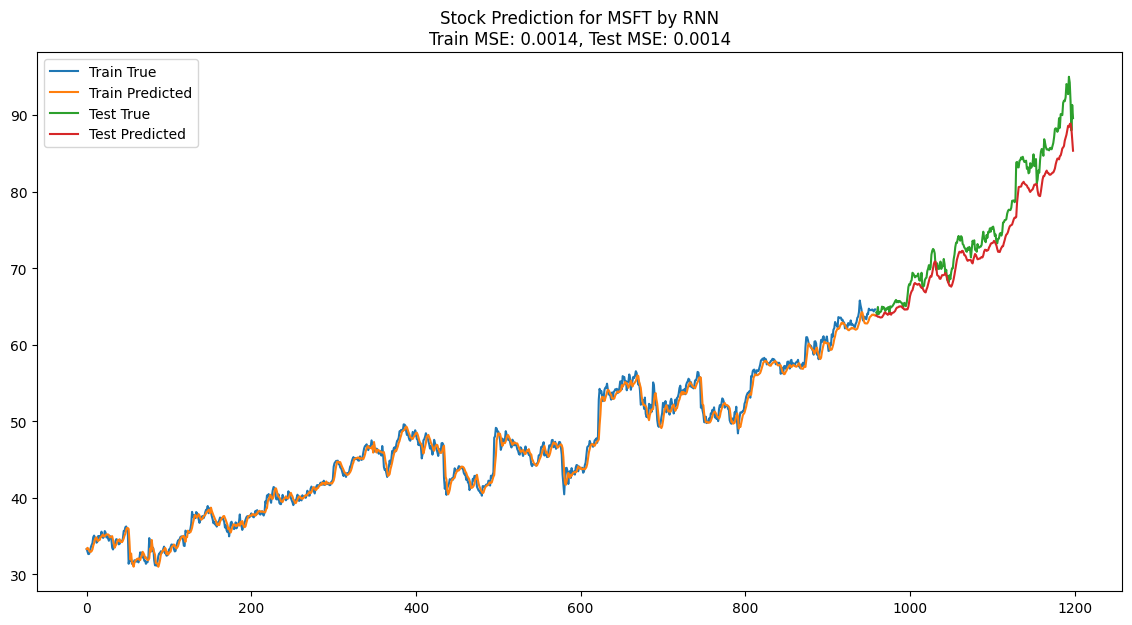

Epoch [10/200], Loss: 0.0185
Epoch [20/200], Loss: 0.0111
Epoch [30/200], Loss: 0.0055
Epoch [40/200], Loss: 0.0025
Epoch [50/200], Loss: 0.0020
Epoch [60/200], Loss: 0.0017
Epoch [70/200], Loss: 0.0017
Epoch [80/200], Loss: 0.0017
Epoch [90/200], Loss: 0.0016
Epoch [100/200], Loss: 0.0015
Epoch [110/200], Loss: 0.0013
Epoch [120/200], Loss: 0.0014
Epoch [130/200], Loss: 0.0013
Epoch [140/200], Loss: 0.0012
Epoch [150/200], Loss: 0.0012
Epoch [160/200], Loss: 0.0012
Epoch [170/200], Loss: 0.0013
Epoch [180/200], Loss: 0.0013
Epoch [190/200], Loss: 0.0012
Epoch [200/200], Loss: 0.0012
GOOG Test MSE: 0.0014


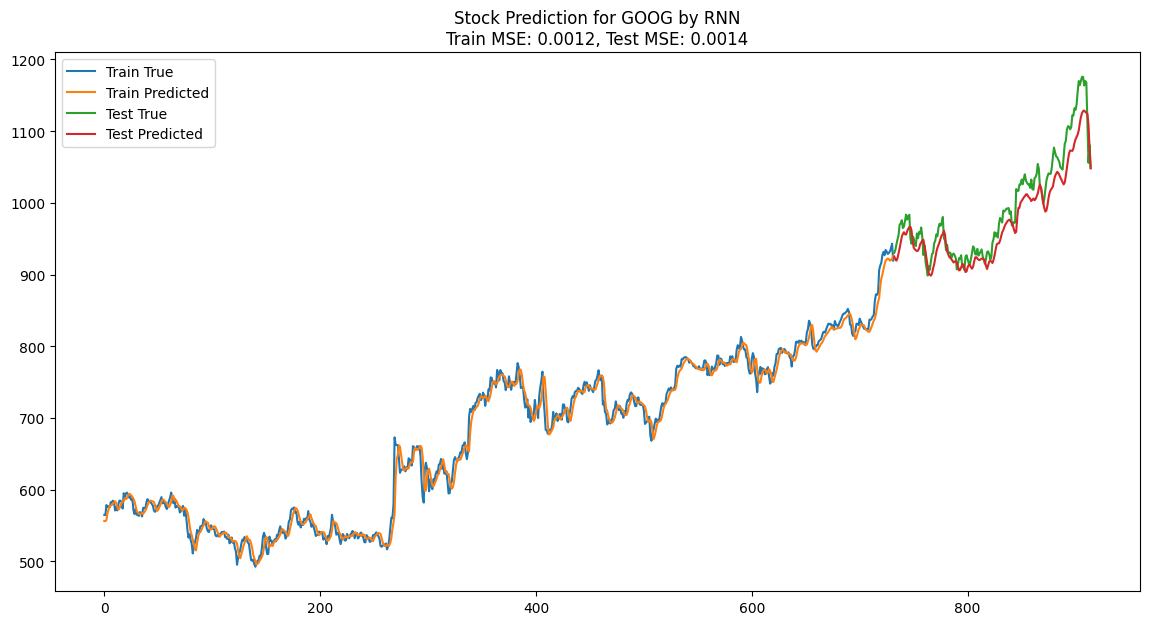

Epoch [10/200], Loss: 0.0100
Epoch [20/200], Loss: 0.0018
Epoch [30/200], Loss: 0.0012
Epoch [40/200], Loss: 0.0012
Epoch [50/200], Loss: 0.0011
Epoch [60/200], Loss: 0.0010
Epoch [70/200], Loss: 0.0010
Epoch [80/200], Loss: 0.0008
Epoch [90/200], Loss: 0.0008
Epoch [100/200], Loss: 0.0007
Epoch [110/200], Loss: 0.0008
Epoch [120/200], Loss: 0.0007
Epoch [130/200], Loss: 0.0007
Epoch [140/200], Loss: 0.0007
Epoch [150/200], Loss: 0.0006
Epoch [160/200], Loss: 0.0006
Epoch [170/200], Loss: 0.0006
Epoch [180/200], Loss: 0.0006
Epoch [190/200], Loss: 0.0005
Epoch [200/200], Loss: 0.0005
AMZN Test MSE: 0.0015


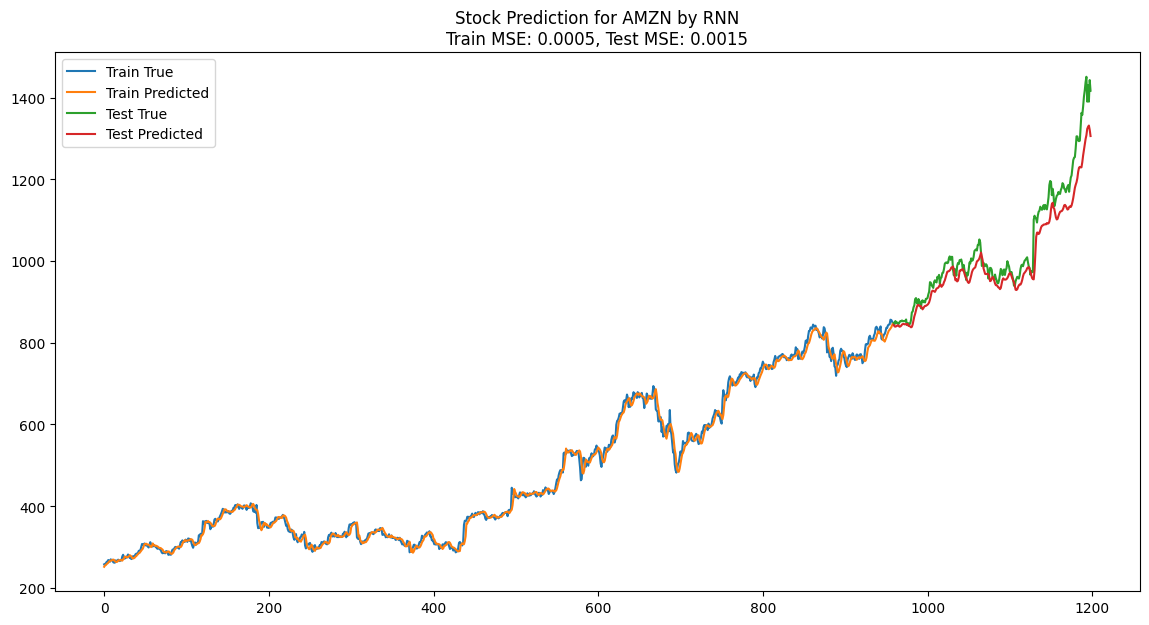

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

data = pd.read_csv('all_stocks_5yr.csv')

def normalize_stock_data(stock_name):
    stock_data = data[data['Name'] == stock_name]
    stock_data = stock_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    stock_data['date'] = pd.to_datetime(stock_data['date'])
    stock_data = stock_data.sort_values('date')
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data[['open', 'high', 'low', 'close', 'volume']] = scaler.fit_transform(stock_data[['open', 'high', 'low', 'close', 'volume']])
    return stock_data, scaler

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Prepare data for a single stock
def prepare_data(stock_name, seq_length=60):
    stock_data, scaler = normalize_stock_data(stock_name)
    X, y = create_sequences(stock_data[['open', 'high', 'low', 'close', 'volume']].values, seq_length)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()[:, 3].unsqueeze(-1)  # 只预测收盘价
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()[:, 3].unsqueeze(-1)  # 只预测收盘价
    return X_train, y_train, X_test, y_test, scaler

# RNN model with dropout
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.rnn(x, h0)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])  # Only take the output from the last time step
        return out

# Training function
def train_model(model, X_train, y_train, num_epochs, criterion, optimizer):
    model.train()
    loss_history = []
    
    for epoch in range(num_epochs):
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    return model, loss_history

# Evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = nn.MSELoss()(predictions, y_test)
    return predictions, mse.item()

def inverse_transform(scaler, predictions, y_test):
    dummy_input = np.zeros((predictions.shape[0], 5))
    dummy_input[:, 3] = predictions.detach().cpu().numpy().flatten()
    dummy_output = scaler.inverse_transform(dummy_input)
    predictions = dummy_output[:, 3]

    dummy_input[:, 3] = y_test.detach().cpu().numpy().flatten()
    dummy_output = scaler.inverse_transform(dummy_input)
    y_test = dummy_output[:, 3]
    
    return predictions, y_test

def plot_results(train_results, test_results, stock_name, train_mse, test_mse):
    plt.figure(figsize=(14, 7))
    plt.plot(train_results['True'], label='Train True')
    plt.plot(train_results['Predicted'], label='Train Predicted')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['True'], label='Test True')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['Predicted'], label='Test Predicted')
    plt.legend()
    plt.title(f'Stock Prediction for {stock_name} by RNN\nTrain MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
    plt.show()

def train_and_evaluate_stock(stock_name, seq_length=60, num_epochs=200, learning_rate=0.001, weight_decay=1e-5):
    X_train, y_train, X_test, y_test, scaler = prepare_data(stock_name, seq_length)
    
    rnn_model = SimpleRNN(input_size=X_train.size(2), hidden_size=50, output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    rnn_model, train_loss_history = train_model(rnn_model, X_train, y_train, num_epochs, criterion, optimizer)
    
    predictions, mse = evaluate_model(rnn_model, X_test, y_test)
    print(f'{stock_name} Test MSE: {mse:.4f}')
    
    train_predictions, y_train = inverse_transform(scaler, rnn_model(X_train), y_train)
    test_predictions, y_test = inverse_transform(scaler, predictions, y_test)
    
    train_results = pd.DataFrame(data={'True': y_train.flatten(), 'Predicted': train_predictions.flatten()})
    test_results = pd.DataFrame(data={'True': y_test.flatten(), 'Predicted': test_predictions.flatten()})
    
    train_mse = train_loss_history[-1]
    
    plot_results(train_results, test_results, stock_name, train_mse, mse)
    
    return rnn_model, train_loss_history

stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN']

for stock in stocks:
    train_and_evaluate_stock(stock)


Epoch [10/200], Loss: 0.0274, Val Loss: 0.0333
Epoch [20/200], Loss: 0.0165, Val Loss: 0.0191
Epoch [30/200], Loss: 0.0099, Val Loss: 0.0103
Epoch [40/200], Loss: 0.0051, Val Loss: 0.0044
Epoch [50/200], Loss: 0.0042, Val Loss: 0.0039
Epoch [60/200], Loss: 0.0036, Val Loss: 0.0036
Epoch [70/200], Loss: 0.0031, Val Loss: 0.0035
Epoch [80/200], Loss: 0.0033, Val Loss: 0.0027
Epoch [90/200], Loss: 0.0031, Val Loss: 0.0033
Epoch [100/200], Loss: 0.0029, Val Loss: 0.0031
Epoch [110/200], Loss: 0.0027, Val Loss: 0.0032
Epoch [120/200], Loss: 0.0027, Val Loss: 0.0028
Epoch [130/200], Loss: 0.0029, Val Loss: 0.0029
Epoch [140/200], Loss: 0.0026, Val Loss: 0.0029
Epoch [150/200], Loss: 0.0024, Val Loss: 0.0026
Epoch [160/200], Loss: 0.0024, Val Loss: 0.0026
Epoch [170/200], Loss: 0.0024, Val Loss: 0.0027
Epoch [180/200], Loss: 0.0023, Val Loss: 0.0026
Epoch [190/200], Loss: 0.0023, Val Loss: 0.0022
Epoch [200/200], Loss: 0.0022, Val Loss: 0.0022
RNN Test MSE: 0.0003


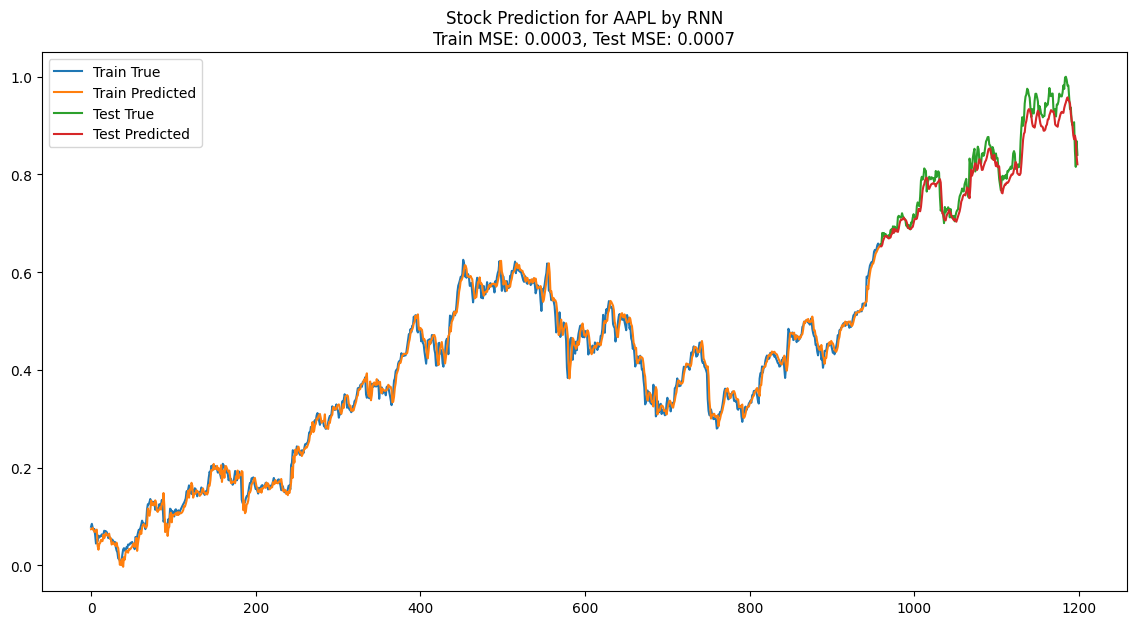

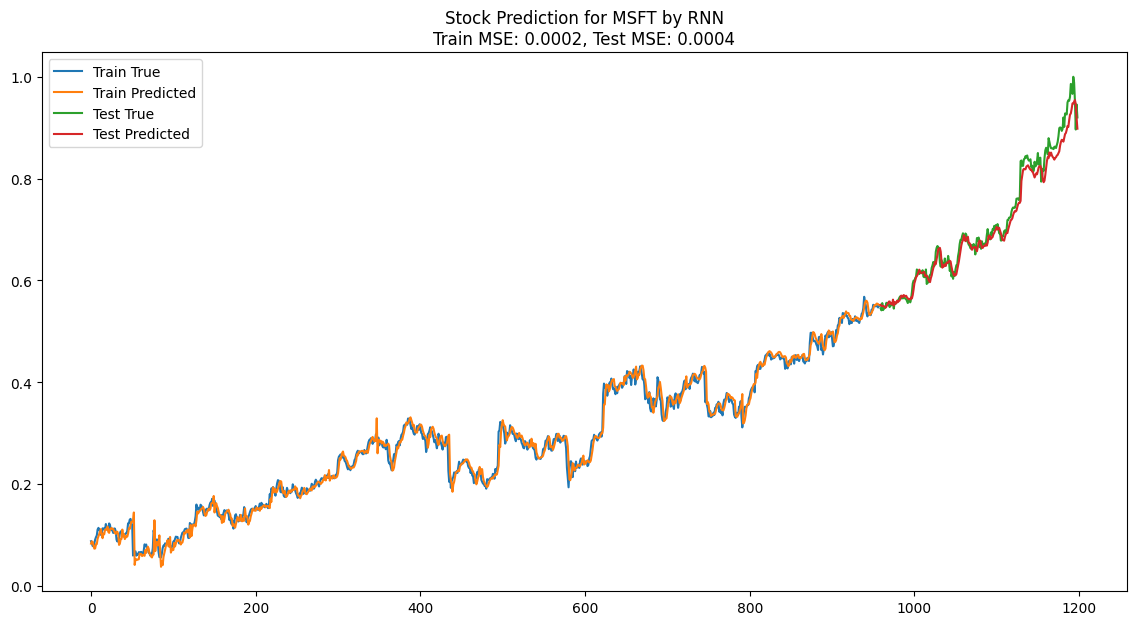

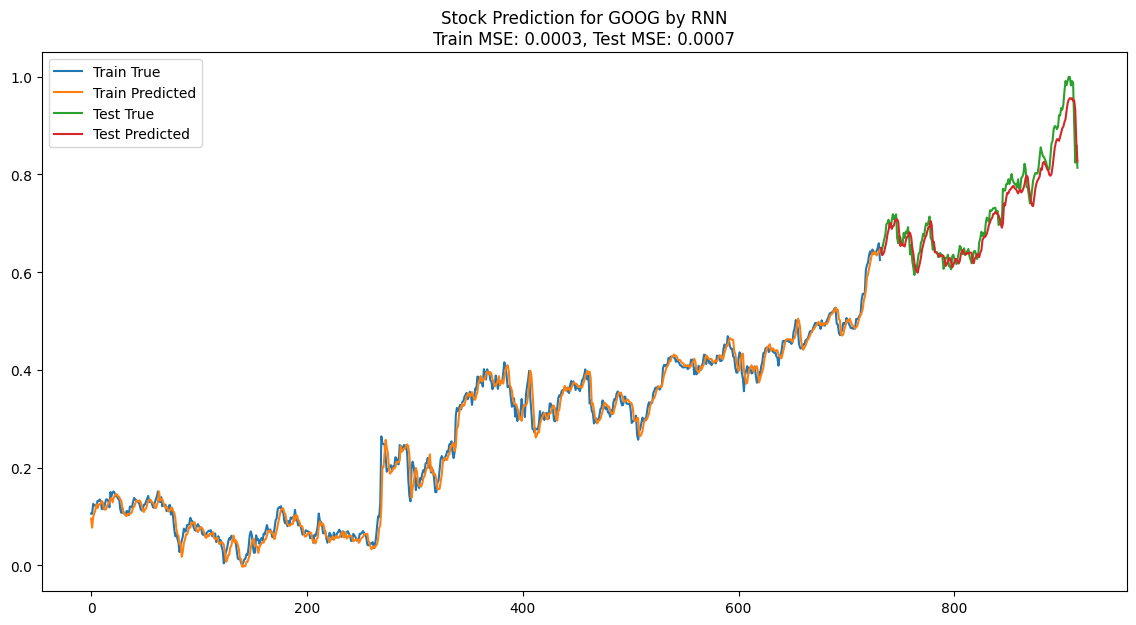

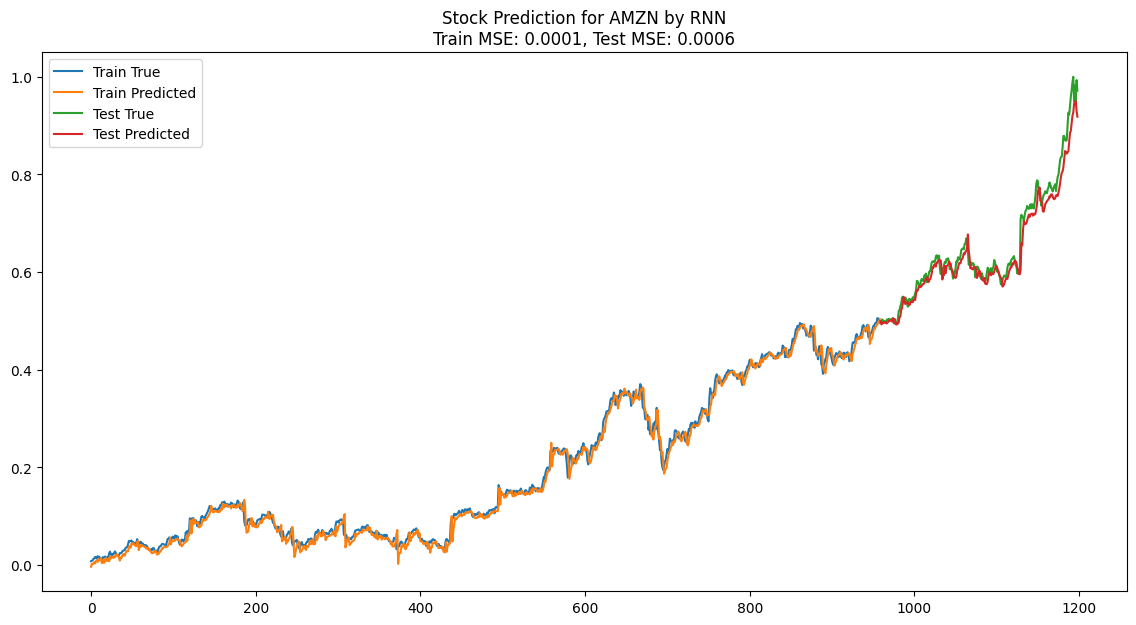

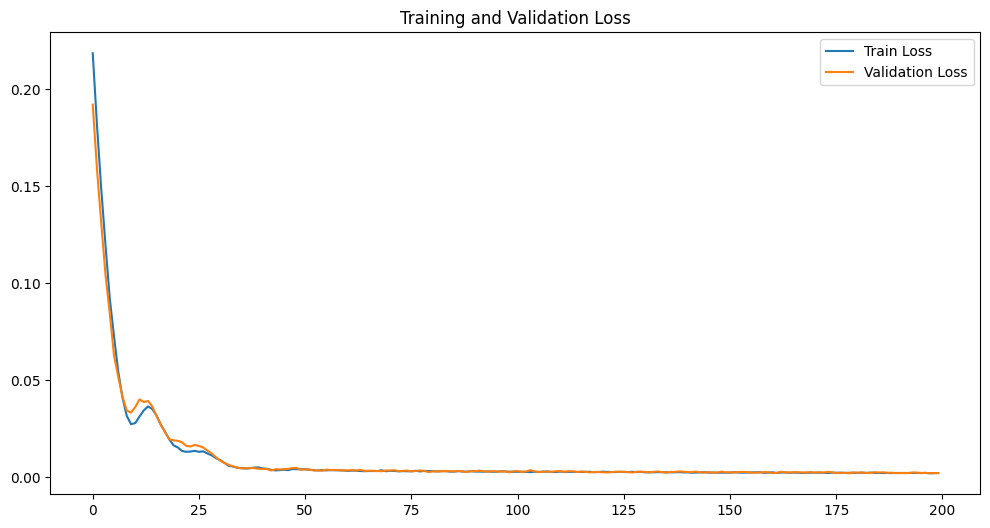

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

data = pd.read_csv('all_stocks_5yr.csv')

def normalize_stock_data(stock_name):
    stock_data = data[data['Name'] == stock_name]
    stock_data = stock_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    stock_data['date'] = pd.to_datetime(stock_data['date'])
    stock_data = stock_data.sort_values('date')
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data[['open', 'high', 'low', 'close', 'volume']] = scaler.fit_transform(stock_data[['open', 'high', 'low', 'close', 'volume']])
    return stock_data, scaler

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length][3] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def prepare_data(stock_names, seq_length=60):
    X, y = [], []
    scalers = {}
    for stock_name in stock_names:
        stock_data, scaler = normalize_stock_data(stock_name)
        stock_sequences, stock_labels = create_sequences(stock_data[['open', 'high', 'low', 'close', 'volume']].values, seq_length)
        X.extend(stock_sequences)
        y.extend(stock_labels)
        scalers[stock_name] = scaler
    X, y = np.array(X), np.array(y)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
    return X_train, y_train, X_test, y_test, scalers

def prepare_single_stock_data(stock_name, seq_length=60):
    stock_data, scaler = normalize_stock_data(stock_name)
    X, y = create_sequences(stock_data[['open', 'high', 'low', 'close', 'volume']].values, seq_length)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
    return X_train, y_train, X_test, y_test, scaler

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.rnn(x, h0)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])  
        return out

def train_model(model, X_train, y_train, X_val, y_val, num_epochs, criterion, optimizer):
    model.train()
    loss_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        
        loss_history.append(loss.item())
        val_loss_history.append(val_loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
    return model, loss_history, val_loss_history

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = nn.MSELoss()(predictions, y_test)
    return predictions, mse.item()

def plot_results(train_results, test_results, stock_name, train_mse, test_mse):
    plt.figure(figsize=(14, 7))
    plt.plot(train_results['True'], label='Train True')
    plt.plot(train_results['Predicted'], label='Train Predicted')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['True'], label='Test True')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['Predicted'], label='Test Predicted')
    plt.legend()
    plt.title(f'Stock Prediction for {stock_name} by RNN\nTrain MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
    plt.show()

stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN']
X_train, y_train, X_test, y_test, scalers = prepare_data(stocks)

val_size = int(len(X_train) * 0.2)
X_val, y_val = X_train[-val_size:], y_train[-val_size:]
X_train, y_train = X_train[:-val_size], y_train[:-val_size]

input_size = 5  
hidden_size = 50
output_size = 1
num_epochs = 200
learning_rate = 0.001
weight_decay = 1e-5  

rnn_model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

rnn_model, train_loss_history, val_loss_history = train_model(rnn_model, X_train, y_train, X_val, y_val, num_epochs, criterion, optimizer)

predictions, mse = evaluate_model(rnn_model, X_test, y_test)
print(f'RNN Test MSE: {mse:.4f}')

def predict_and_plot_stock(stock_name):
    X_train_stock, y_train_stock, X_test_stock, y_test_stock, scaler_stock = prepare_single_stock_data(stock_name)
    
    train_predictions_stock = rnn_model(X_train_stock).detach().cpu().numpy()
    test_predictions_stock = rnn_model(X_test_stock).detach().cpu().numpy()
    
    train_mse_stock = np.mean((y_train_stock.cpu().numpy() - train_predictions_stock)**2)
    test_mse_stock = np.mean((y_test_stock.cpu().numpy() - test_predictions_stock)**2)
    
    train_results_stock = pd.DataFrame(data={'True': y_train_stock.cpu().numpy().flatten(), 'Predicted': train_predictions_stock.flatten()})
    test_results_stock = pd.DataFrame(data={'True': y_test_stock.cpu().numpy().flatten(), 'Predicted': test_predictions_stock.flatten()})
    
    plot_results(train_results_stock, test_results_stock, stock_name, train_mse_stock, test_mse_stock)

for stock in stocks:
    predict_and_plot_stock(stock)

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()